## Create reports for several recordings

In [54]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
from tinnsleep.config import Config
from tinnsleep.create_reports import preprocess, reporting
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd
import pickle
import scipy
from tinnsleep.config import Config

print("config loaded")


config loaded


In [3]:
#Setting parameters
EDF_list = Config.bruxisme_files
THR_classif=[[0,2], [0,3], [0,4], [0,5] , [0,6], [0,7], [0,8], [0,9], [0,10]]
sfreq = 200
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping


df = pd.read_pickle("Resources/valid_chans_THR_imp.pickle")
dico_chans= df.to_dict("list")

print("parameters set")


parameters set


In [4]:
import warnings

#EDF_list=['E:/Acou_sommeil/EDF_V2_PAUL\\jon_mema.edf']

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    for filename in EDF_list:
        #opens the raw file
        raw = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
        print(filename)
        #Get channels indexes
        ind_picks_chan= dico_chans[filename.split("\\")[-1]][0]
        ind_picks_imp= dico_chans[filename.split("\\")[-1]][1]
        #Get THR_imp value for filename
        THR_imp = dico_chans[filename.split("\\")[-1]][2]
        
        #Get channel names from indexes
        if len(ind_picks_chan)>0: #ignore file if no channel is good
            picks_chan=[]
            for elm in ind_picks_chan:
                picks_chan.append(raw.info["ch_names"][elm])
            picks_imp=[]
            for elm in ind_picks_imp:
                picks_imp.append(raw.info["ch_names"][elm])
            print(picks_chan)
            print(picks_imp)
            
            #Setting parameters for is_good
            params = dict(ch_names=picks_chan,
                  rejection_thresholds=dict(emg=1e-04),  # two order of magnitude higher q0.01
                  flat_thresholds=dict(emg=1e-09),  # one order of magnitude lower median
                  channel_type_idx=dict(emg=[ i for i in range(len(picks_chan))]),
                  full_report=True
                  )
            # Get the preprocessing steps done
            epochs, valid_labels, log = preprocess(raw, picks_chan, picks_imp, duration, interval, params, THR_imp=THR_imp, get_log=True)
            #If at least one epoch is good create report
            if np.sum(valid_labels)>0 : 
                results[filename] = reporting(epochs, valid_labels, THR_classif, log)


Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1BA07_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\1BA07_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']
burst list empty
burst list empty
burst list empty
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1BA07_nuit_son.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\1BA07_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']
burst list empty
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1CC05_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\1CC05_nuit_hab.edf
['1', '2']
['1 Impedance', '2 Impedance']
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1CC05_nuit_son.edf...
EDF file detected
Setting channel info st

Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\HZB_nuit_2.edf
['1', '1-F']
['1 Imp?dance', '1-F (Imp)']
burst list empty
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\HZB_nuit_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\HZB_nuit_3.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\SCHMIDTLIN_nuit_1_dec_OD__0to0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\SCHMIDTLIN_nuit_1_dec_OD__0to0.edf
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/Acou_sommeil/EDF_V2_PAUL\SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf
['1']
['1 Imp?dance']
burst list empty
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAU

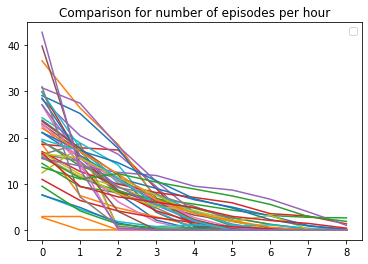

In [33]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of episodes per hour"])
    st = elm[-19:] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for number of episodes per hour')
plt.legend()


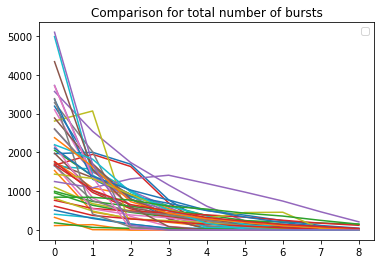

In [40]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm[-19:] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for total number of bursts')
plt.legend()

In [5]:
print(len(results.keys()))
compt=0
for elm in results.keys():
    if results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs'] > 0.0001:
        print (elm)
        print(results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs'])
        print(results[elm]["log"]['suppressed_imp_THR'])
        print(results[elm]["log"]['suppressed_amp_THR'])
        print("")
        compt+=1
print(compt)

45
E:/Acou_sommeil/EDF_V2_PAUL\1BA07_nuit_hab.edf
0.02433606041535557
0
3867

E:/Acou_sommeil/EDF_V2_PAUL\1BA07_nuit_son.edf
0.008806702084184716
0
862

E:/Acou_sommeil/EDF_V2_PAUL\1CC05_nuit_hab.edf
0.022173228346456693
0
3520

E:/Acou_sommeil/EDF_V2_PAUL\1CC05_nuit_son.edf
0.041498176997016904
0
5008

E:/Acou_sommeil/EDF_V2_PAUL\1DA15_nuit_hab.edf
0.022842337750594632
0
2689

E:/Acou_sommeil/EDF_V2_PAUL\1DA15_nuit_son.edf
0.13180837954405422
12956
4389

E:/Acou_sommeil/EDF_V2_PAUL\1DL12_nuit_hab.edf
0.18917391304347825
29786
1083

E:/Acou_sommeil/EDF_V2_PAUL\1DL12_nuit_son.edf
0.11169514695830485
15446
8384

E:/Acou_sommeil/EDF_V2_PAUL\1GB18_nuit_son.edf
0.23249171880750827
22166
11055

E:/Acou_sommeil/EDF_V2_PAUL\1GB19_nuit_hab.edf
0.026681861049984282
0
3395

E:/Acou_sommeil/EDF_V2_PAUL\1GF14_nuit_son.edf
0.163497463099631
15446
15948

E:/Acou_sommeil/EDF_V2_PAUL\1MA16_nuit_hab.edf
0.021876155268022182
0
2367

E:/Acou_sommeil/EDF_V2_PAUL\1MA16_nuit_son.edf
0.007057769816390506
0
78

In [24]:
def open_dict(name):
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    return(b)

print(os.getcwd())
#os.chdir(".../Resources")
get_pickle=open_dict("evolution_acous_nuits_masquage_v2_metaData_stats")
evol_masking = get_pickle["results"]
print(evol_masking[-3:])
#print(evol_masking)
get_scores=[]
for elm in results.keys():
        #print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            l_ep_h.append(ep["Number of episodes per hour"])

        get_scores.append([elm.split("\\")[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

C:\Users\Zeta\Documents\acou_sommeil_HD_ENS\Tinnitus-n-Sleep\Notebooks\Resources
[['SCHM_nuit_1.edf', -4, -0.08888888888888889], ['Unger_2.edf', 10, 0.18518518518518517], ['unger_nuit_1.edf', 5, 0.10638297872340426]]
45
[['sophie_mema.edf', [13.565600600360856, 11.036420827412222, 12.186047996934327, 10.346644525698958, 8.85212920532022, 7.357613884941481, 5.518210413706111, 2.8740679238052658, 1.8394034712353702]], ['tom_mema.edf', [16.606639107215727, 9.453009953338183, 7.153629153877544, 6.003938754147224, 4.854248354416905, 2.9380976881997056, 2.0438940439650124, 1.405177155225946, 0.38323013324343985]], ['unger_nuit_1.edf', [42.80844323542578, 13.05740160462794, 0.3305671292310871, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


1ZN04_nuit_hab.edf
1ZN04_nuit_son.edf
1CC05_nuit_hab.edf
1CC05_nuit_son.edf
1PT06_nuit_hab.edf
1PT06_nuit_son.edf
1PI07_nuit_hab.edf
1PI07_nuit_son.edf
1BA07_nuit_hab.edf
1BA07_nuit_son.edf
1MN09_nuit_hab.edf
1MN09_nuit_son.edf
1DL12_nuit_hab.edf
1DL12_nuit_son.edf
1GF14_nuit_son.edf
1SA14_nuit_hab.edf
1SA14_nuit_son.edf
1DA15_nuit_hab.edf
1DA15_nuit_son.edf
1MA16_nuit_son.edf
1RA17_nuit_son.edf
1GB18_nuit_son.edf
1MF19_nuit_hab.edf
1MF19_nuit_son.edf
HZB_nuit_1.edf
HZB_nuit_2.edf
Unger_2.edf
unger_nuit_1.edf


Text(0.5, 1.0, 'comparaison nb episodes par heure (y) entre patients avec augmentation (orange) et patients sans augmentation (bleu) suivant les valeurs de THR_classif (x)')

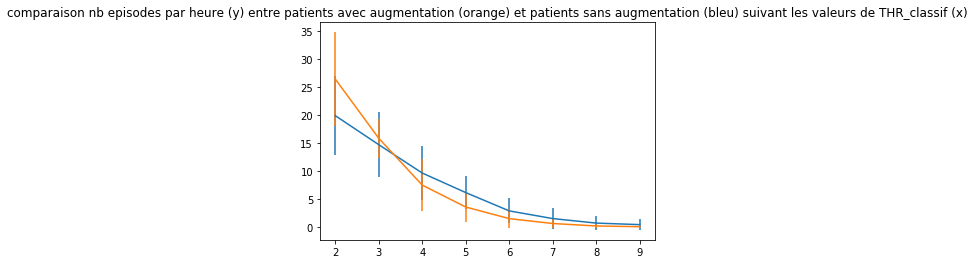

In [68]:
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
scat=[[] for i in range(8)]
pourc_scat=[[] for i in range(8)]
augm=[[] for i in range(8)]
stable=[[] for i in range(8)]
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            for j in range(8):
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 : 
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            print(elm[0])
            if (elm[2]>0):
                for j in range(8):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(8):
                    stable[j].append(get_scores[i][1][j])
            
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
plt.figure()
plt.errorbar([i+2 for i in range(8)],stable_m, stable_std)
plt.errorbar([i+2 for i in range(8)], augm_m, augm_std)
plt.title("comparaison nb episodes par heure (y) entre patients avec augmentation (orange) et patients sans augmentation (bleu) suivant les valeurs de THR_classif (x)" )

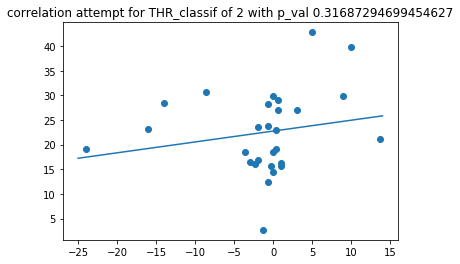

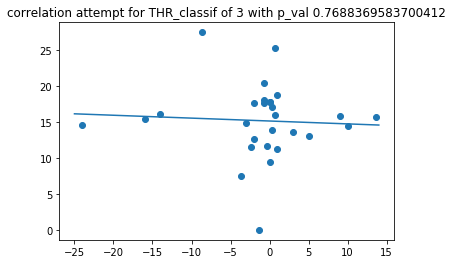

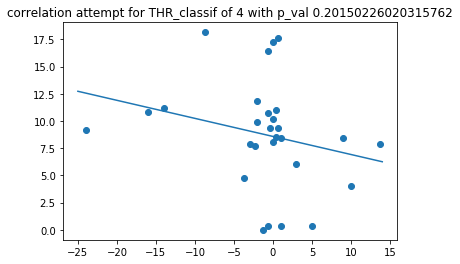

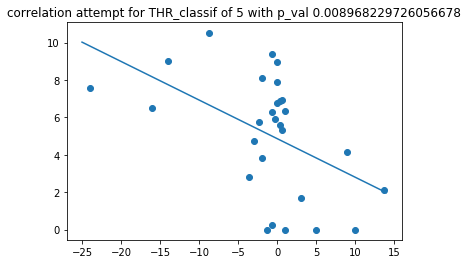

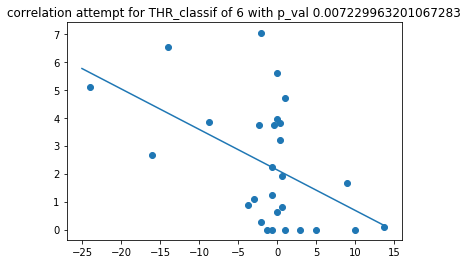

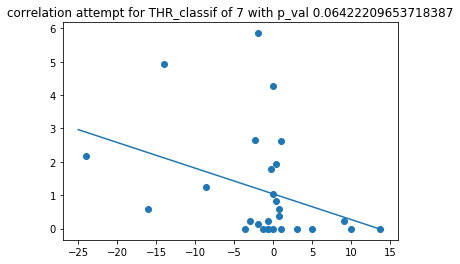

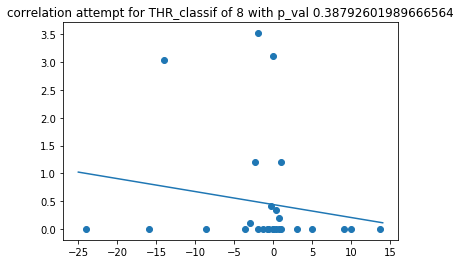

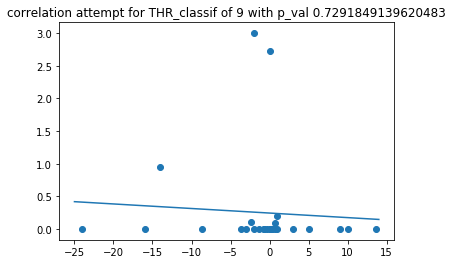

In [71]:
for j in range(8):
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str(regre[3]))

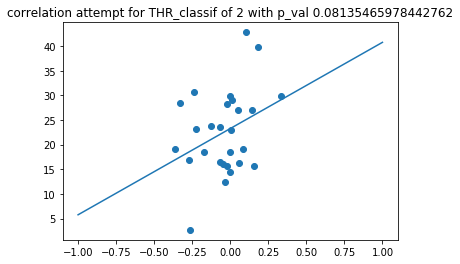

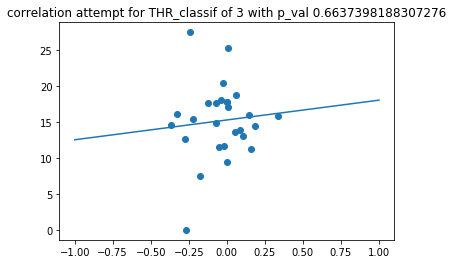

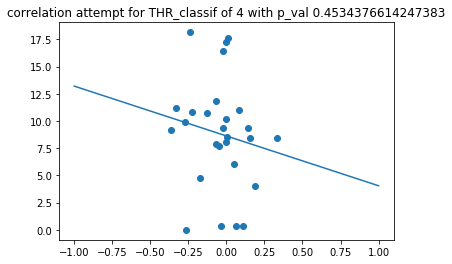

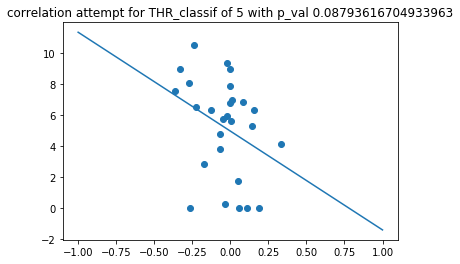

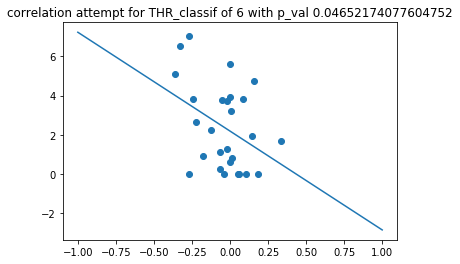

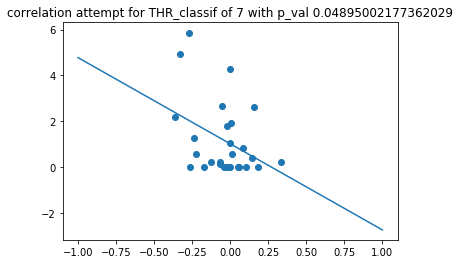

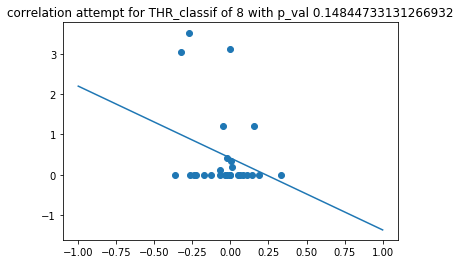

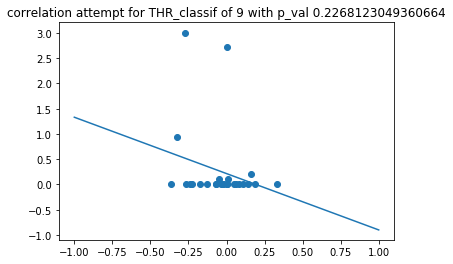

In [79]:
for j in range(8):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    #print(j+2)
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    #plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str(regre[3]))